In [1]:
!pip install keras_tuner
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 34.3 MB/s eta 0:00:00


In [2]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 446.2 kB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/My Drive/Cam101"

Mounted at /content/drive/
/content/drive/My Drive/Cam101


In [5]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import tensorflow_hub as hub
import random
import tensorflow_addons as tfa
import cv2
import segmentation_models as sm
import keras_tuner as kt
import matplotlib.pyplot as plt
import keras_tuner as kt
import keras.backend as K
import time
from glob import glob
from PIL import Image
from numpy import load
from numpy import save
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential,load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner import HyperModel
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Segmentation Models: using `tf.keras` framework.


In [6]:
#this code block imports saved numpy data so ram is used efficiently
x_train_aug = load('x_train_aug.npy')

dict_data = load('y_train_encoded.npz')
y_train_encoded = dict_data['arr_0']

x_test = load('x_test.npy')
y_test = load('y_test.npy')
y_test_mask = load('y_test_mask.npy')

In [7]:
#get directory path for all images in train and test
x_train_path = sorted(glob('train/0016E5_*[!_L].png'))
y_train_path = sorted(glob('train/0016E5_*_L.png'))

x_test_path = sorted(glob('test/0016E5_*[!_L].png'))
y_test_path = sorted(glob('test/0016E5_*_L.png'))

#read the labels txt file and make a dict mapping for class number and rgb value and another dict for class number and name
mapping = pd.read_csv("label_colors.txt", delim_whitespace=True, header = None)
rgb_val = mapping.to_numpy()[:,:3].astype(float)
labels = mapping.to_numpy()[:,3].astype(str)

label_dict = {}
label_dict_int = {}

for i in range(len(mapping)):
  label_dict[labels[i]] = rgb_val[i]
  label_dict_int[i] = rgb_val[i]

In [ ]:
#display train and test data
print("Number of images in train data:", len(x_train_path))
print("Number of images in test data:", len(x_test_path))

Number of images in train data: 90
Number of images in test data: 11


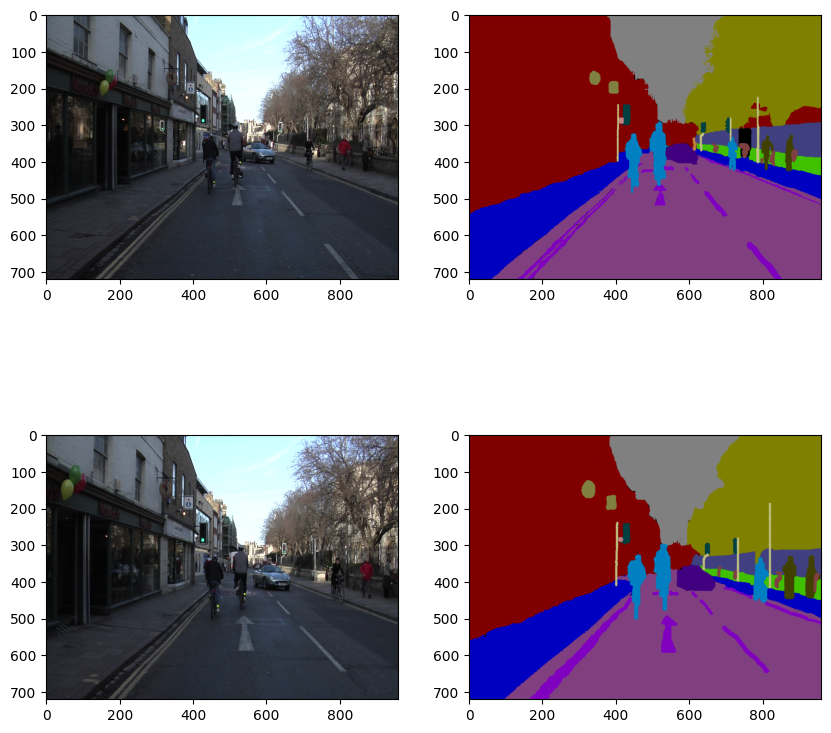

In [ ]:
#display train data
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    x_img = plt.imread(x_train_path[(i+3)**2])
    y_img = plt.imread(y_train_path[(i+3)**2])
    ax[i][0].imshow(x_img)
    ax[i][1].imshow(y_img)

plt.show()

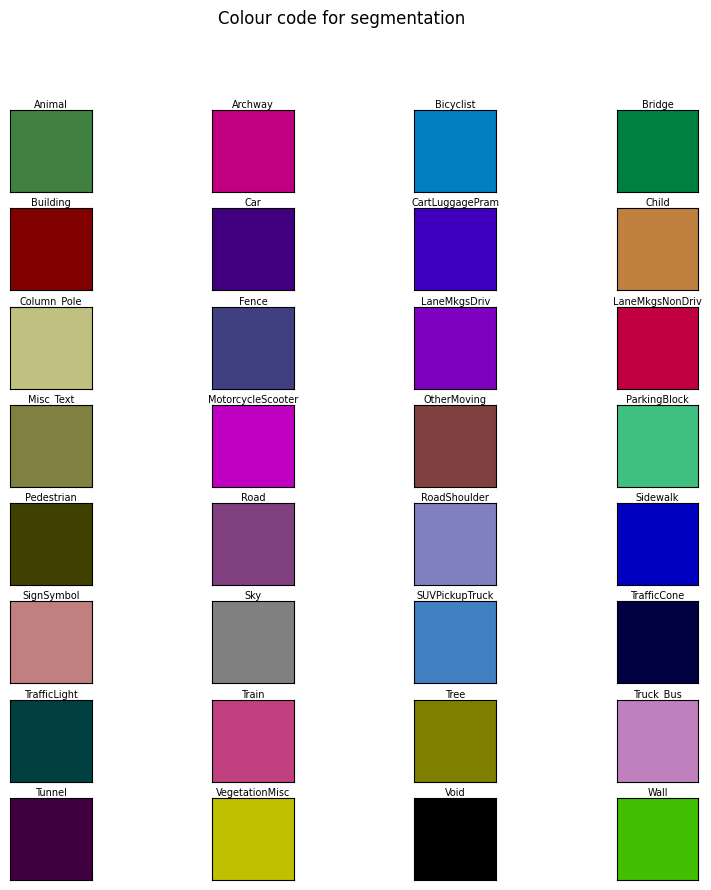

In [ ]:
#display colour code for each class
palette = []
palette_label = []
for b in label_dict:
  palette.append(label_dict[b].astype(int))
  palette_label.append(b)

fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(10,10))
count = 0
for i in range(8):
  for j in range(4):
    ax[i,j].imshow([[tuple(palette[count])]])

    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

    ax[i,j].set_title(palette_label[count], size=7, pad=-4)

    count+=1

fig.suptitle('Colour code for segmentation')
plt.show()

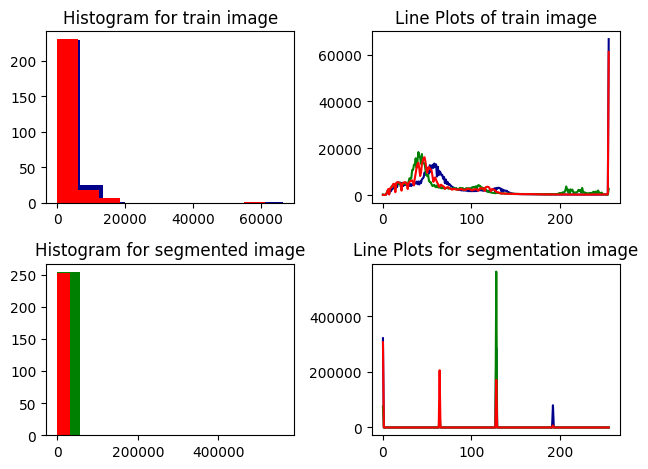

In [ ]:
#display histogram for image and its mask

#read image
image = cv2.imread(x_train_path[0])
mask = cv2.imread(y_train_path[0])

#calculate image histogram
blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
red_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
green_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 

#calculate mask histogram 
blue_histogram_mask = cv2.calcHist([mask], [0], None, [256], [0, 256])
red_histogram_mask = cv2.calcHist([mask], [1], None, [256], [0, 256])
green_histogram_mask = cv2.calcHist([mask], [2], None, [256], [0, 256]) 

#plot histograms and line plots
plt.subplot(2,2,1)
plt.title("Histogram for train image")
plt.hist(blue_histogram,color="darkblue")
plt.hist(green_histogram,color="green")
plt.hist(red_histogram,color="red")
 
plt.subplot(2,2,2)
plt.title("Line Plots of train image")
plt.plot(blue_histogram,color="darkblue")
plt.plot(green_histogram,color="green")
plt.plot(red_histogram,color="red")
 
plt.subplot(2,2,3)
plt.title("Histogram for segmented image")
plt.hist(blue_histogram_mask,color="darkblue")
plt.hist(green_histogram_mask,color="green")
plt.hist(red_histogram_mask,color="red")

plt.subplot(2,2,4)
plt.title("Line Plots for segmentation image")
plt.plot(blue_histogram_mask,color="darkblue")
plt.plot(green_histogram_mask,color="green")
plt.plot(red_histogram_mask,color="red")

plt.tight_layout()
plt.show()

In [8]:
#function to convert rgb mask to single channel mask
def convert_label_to_index(im):
  mask = []
  out = (np.zeros(im.shape[:2]))

  for rgb in label_dict_int:
    seg_pixls = np.where((im == np.asarray(label_dict_int[rgb])).sum(-1) == 3)
    out[seg_pixls] = rgb
  
  return out

#function to convert single channel mask to rgb mask
def convert_index_to_label(im):
  img_classes = im
  h, w = img_classes.shape
  img_rgb = np.zeros((h, w, 3), dtype=np.uint8)
  
  for gray, rgb in label_dict_int.items():
    img_rgb[img_classes == gray, :] = rgb

  return img_rgb

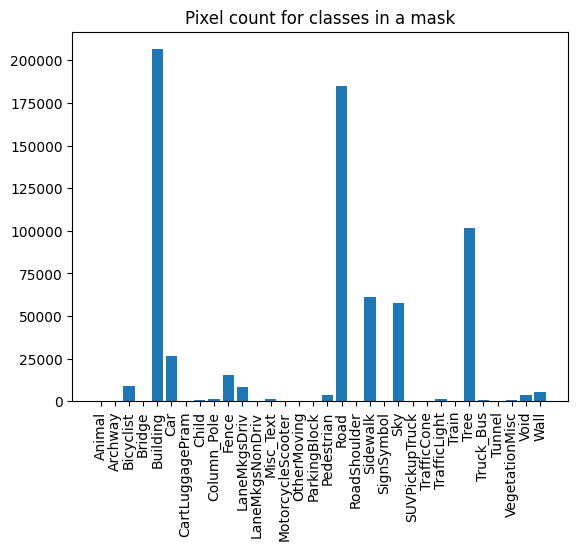

In [ ]:
#display pixel count for classes in a mask to understand the data
im = plt.imread(y_train_path[0])*255
im = convert_label_to_index(im)

count = []
for i in range(32):
  c = np.count_nonzero(im==i)
  count.append(c)

plt.bar(palette_label, count)
plt.xticks(range(len(palette_label)), palette_label, rotation='vertical')
plt.title('Pixel count for classes in a mask')
plt.show()

#Preprocessing Data

In [ ]:
#function to resize data as the pretrained models only accepts images divisible by 48

def image(im):
  im = plt.imread(im)
  im = cv2.resize(im, dsize=(960, 672), interpolation=cv2.INTER_CUBIC)
  return im

#function to convert images to numpy arrays
def image_to_np(data):
  x = np.array(list(map(image, data)))

  return x

#function return values between 0-1 so mulitply by 255.0. np round is used for y_train to make all the values int
x_train = image_to_np(x_train_path)*255.0
y_train = np.round(image_to_np(y_train_path)*255.0)

x_test = image_to_np(x_test_path)*255.0
y_test = image_to_np(y_test_path)

In [ ]:
#save numpy arrays onto google drive for future use

#save('x_train.npy',x_train)
#save('y_train.npy',y_train)

#save('x_test.npy',x_test)
#save('y_test.npy',y_test)

In [ ]:
#function to augment data
def data_aug(x, y):
  x_aug = []
  y_aug = []

  for i in range(len(x)):
    #randomly choose images that get augmented
    if (random.choices([True, False],(10,90)))[0]:
      #append original image to lists
      x_aug.append(x[i])
      y_aug.append(y[i])

      #for the image and mask commit rotation, flip and brightness(brightness is not applied for mask) augmentation
      temp_x = tfa.image.rotate(x[i],0.1)
      temp_x = tf.image.flip_left_right(temp_x)
      temp_x = tf.image.adjust_brightness(temp_x,-0.1)

      temp_y = tfa.image.rotate(y[i],0.1)
      temp_y = tf.image.flip_left_right(temp_y)

      #append augmented image and mask to list
      x_aug.append(temp_x)
      y_aug.append(temp_y)

    else:
      #if image is not chosen for augmentation append it to list
      x_aug.append(x[i])
      y_aug.append(y[i])
    
  return np.array(x_aug), np.array(y_aug)

#augment train data
x_train_aug, y_train_aug = data_aug(x_train, y_train)


In [ ]:
#save augmented data to drive for future use

#save('x_train_aug.npy', x_train_aug)
#save('y_train_aug.npy', y_train_aug)

In [ ]:
print("Number of images in augmented train data:", len(x_train_aug))

Number of images in augmented train data: 101


In [ ]:

x_mask = []
#convert augmented masks to single channel mask
for im in y_train_aug:
  m = convert_label_to_index(im)
  x_mask.append(m)

y_mask = []

#converted test masks to single channel mask
for im in y_test:
  m = convert_label_to_index(im)
  y_mask.append(m)

y_train_mask = np.array(x_mask)
y_test_mask = np.array(y_mask)

In [ ]:
#save data for future use

#save('y_train_mask.npy', y_train_mask)
#save('y_test_mask.npy', y_test_mask)

In [ ]:
#y_train_mask = np.load('y_train_mask.npy')
enc = []

#convert train mask to 32 channel one hot encoded array
for im in y_train_mask:
  m = tf.one_hot(im,depth=32)
  enc.append(m)

y_train_encoded = np.array(enc)

In [ ]:
#save one hot encoded data to drive

#np.savez_compressed('y_train_encoded.npz', y_train_encoded)

#Semantic models

In [20]:
#class that contains all semantic segmentation models

class semantic_segmentation(HyperModel):

  #init function takes training data and number classes as input
  def __init__(self, x, y, classes=32):
    self.x = x
    self.y = y
    self.classes = classes

  #function to optimize unet model
  def build_unet(self, hp):
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop'])
    hp_loss = hp.Choice('loss', values = ['dice', 'cc'])
    

    model = self.unet(optimizer = hp_optimizer, loss=hp_loss)

    return model

  #function to optimize fpn model
  def build_fpn(self, hp):
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop'])
    hp_loss = hp.Choice('loss', values = ['dice', 'cc'])
    

    model = self.fpn(optimizer = hp_optimizer, loss=hp_loss)

    return model

  #function to optimize psp model
  def build_psp(self, hp):
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop'])
    hp_loss = hp.Choice('loss', values = ['dice', 'cc'])
    

    model = self.psp(optimizer = hp_optimizer, loss=hp_loss)

    return model

  #build and compile unet model
  def unet(self, backbone='resnet18', 
           encoder_weights='imagenet', 
           activation='softmax', 
           optimizer='adam', 
           loss=sm.losses.dice_loss, 
           metrics=sm.metrics.iou_score):
    
    #if-else for hyperband optimization
    if loss == 'dice':
      loss = sm.losses.dice_loss
    elif loss == 'cc':
      loss = sm.losses.categorical_crossentropy
    else:
      pass

    model = sm.Unet(backbone_name=backbone, encoder_weights=encoder_weights, activation=activation, classes=self.classes, input_shape=(672, 960, 3))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, pixelwise_accuracy])
    model.summary()

    return model

  #train unet
  def unet_train(self, model, batch_size=4, epochs=5, validation_split=0.1):
    start_time = time.time()
    history = model.fit(self.x, self.y, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    print('Training time: {} minutes'.format((time.time()-start_time)/60))

    return history
    
  #function to build and compile linknet  
  def linknet(self, backbone='resnet18', 
              encoder_weights='imagenet', 
              activation='softmax', 
              optimizer='adam', 
              loss=sm.losses.dice_loss, 
              metrics=sm.metrics.iou_score):
    
    #if-else for hyperband optimization
    if loss == 'dice':
      loss = sm.losses.dice_loss
    elif loss == 'cc':
      loss = sm.losses.categorical_crossentropy
    else:
      pass
    
    model = sm.Linknet(backbone_name=backbone, encoder_weights=encoder_weights, activation=activation, classes=self.classes)
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, pixelwise_accuracy])
    model.summary()

    return model

  #function to train linknet
  def linknet_train(self, model, batch_size=4, epochs=5, validation_split=0.1):
    start_time = time.time()
    history = model.fit(self.x, self.y, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    print('Training time: {} minutes'.format((time.time()-start_time)/60))

    return history

  #function to build and compile fpn
  def fpn(self, backbone='resnet34', 
          encoder_weights='imagenet', 
          activation='softmax', 
          optimizer='adam', 
          loss=sm.losses.dice_loss, 
          metrics=sm.metrics.iou_score):
    
    #if-else for hyperband optimization
    if loss == 'dice':
      loss = sm.losses.dice_loss
    elif loss == 'cc':
      loss = sm.losses.categorical_crossentropy
    else:
      pass
    
    model = sm.FPN(backbone_name=backbone, encoder_weights=encoder_weights, activation=activation, classes=self.classes)

    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, pixelwise_accuracy])
    model.summary()

    return model

  #function to train fpn
  def fpn_train(self, model, batch_size=4, epochs=5, validation_split=0.1):
    start_time = time.time()
    history = model.fit(self.x, self.y, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    print('Training time: {} minutes'.format((time.time()-start_time)/60))

    return history

  #function to build and compile pspnet
  def psp(self, backbone='resnet18', 
          encoder_weights='imagenet', 
          activation='softmax', 
          optimizer='adam', 
          loss=sm.losses.dice_loss, 
          metrics=sm.metrics.iou_score):
    
    #if-else for hyperband optimization
    if loss == 'dice':
      loss = sm.losses.dice_loss
    elif loss == 'cc':
      loss = sm.losses.categorical_crossentropy
    else:
      pass
    
    model = sm.PSPNet(backbone_name=backbone, encoder_weights=encoder_weights, activation=activation, classes=self.classes, input_shape=(672,960,3))

    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, pixelwise_accuracy])
    model.summary()

    return model

  #function to train pspnet
  def psp_train(self, model, batch_size=4, epochs=10, validation_split=0.1):
    start_time = time.time()
    history = model.fit(self.x, self.y, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    print('Training time: {} minutes'.format((time.time()-start_time)/60))

    return history
  
    


#custom metric for calculating pixelwise accuracy during training

def pixelwise_accuracy(target, output):
  #convert 32 channel mask to single channel
  out = K.argmax(output, axis=-1)
  true = K.argmax(target, axis=-1)

  #calculate denominator multiplier based on batch size
  if len(tf.shape(true))==3:
    denom = tf.shape(true)[0]
  else:
    denom = tf.constant(1)

  #find total correctly classfied pixels
  equal = tf.math.equal(out,true)
  cast = tf.cast(equal, tf.int32)
  total = tf.reduce_sum(cast)

  #calculate pixelwise accuracy
  score = total/(tf.shape(true)[-1]*tf.shape(true)[-2]*denom)
  
  return score

In [21]:
#build models
ss = semantic_segmentation(x_train_aug, y_train_encoded)

mod = 'FPN'

if mod == 'UNET':
  model = ss.unet()
elif mod == 'PSP':
  model = ss.psp()
elif mod=='FPN':
  model = ss.fpn()
else:
  model = ss.linknet()
  


85521592/85521592 [==============================] - 5s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [22]:
#train models
if mod == 'UNET':
  start_time = time.time()
  history = ss.unet_train(model,epochs=10,batch_size=2)
  train_time_unet = (time.time()-start_time)/60

elif mod == 'PSP':
  start_time = time.time()
  history = ss.psp_train(model, epochs=10, batch_size=2)
  train_time_psp = (time.time()-start_time)/60


elif mod == 'FPN':
  start_time = time.time()
  history = ss.fpn_train(model,epochs=10,batch_size=2)
  train_time_fpn = (time.time()-start_time)/60

else:
  start_time = time.time()
  history = ss.linknet_train(model,epochs=10,batch_size=2)
  train_time_link = (time.time()-start_time)/60


Epoch 1/10
45/45 [==============================] - 36s 201ms/step - loss: 0.7149 - iou_score: 0.2314 - pixelwise_accuracy: 0.8183 - val_loss: 0.9487 - val_iou_score: 0.0300 - val_pixelwise_accuracy: 0.1284
Epoch 2/10
45/45 [==============================] - 7s 154ms/step - loss: 0.5818 - iou_score: 0.3499 - pixelwise_accuracy: 0.8863 - val_loss: 0.9271 - val_iou_score: 0.0452 - val_pixelwise_accuracy: 0.1732
Epoch 3/10
45/45 [==============================] - 7s 153ms/step - loss: 0.5282 - iou_score: 0.4054 - pixelwise_accuracy: 0.9103 - val_loss: 0.8926 - val_iou_score: 0.0701 - val_pixelwise_accuracy: 0.1741
Epoch 4/10
45/45 [==============================] - 7s 154ms/step - loss: 0.4964 - iou_score: 0.4395 - pixelwise_accuracy: 0.9215 - val_loss: 0.6690 - val_iou_score: 0.2694 - val_pixelwise_accuracy: 0.7995
Epoch 5/10
45/45 [==============================] - 7s 154ms/step - loss: 0.4829 - iou_score: 0.4544 - pixelwise_accuracy: 0.9273 - val_loss: 0.6845 - val_iou_score: 0.2534 - 

In [ ]:
print('Training time for UNET: {} minutes'.format(train_time_unet))

Training time for UNET: 3.4079197724660237 minutes


In [ ]:
print('Training time for PSPNET: {} minutes'.format(train_time_psp))

Training time for PSPNET: 2.6589926560719808 minutes


In [ ]:
print('Training time for FPN: {} minutes'.format(train_time_fpn))

Training time for FPN: 1.9827047785123189 minutes


#Model optimization
The following blocks optimize the three models using hyperband optimization

In [ ]:
#build model
hypermodel_unet = semantic_segmentation(x_train_aug[:10], y_train_encoded[:10]).build_unet

#build tuner using hyperband
tuner_unet = kt.Hyperband(hypermodel_unet,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_epochs = 10,
                     directory = 'unet',
                     project_name = 'unet_optimization')

#search for best params
tuner_unet.search(x_train_aug[:10], y_train_encoded[:10], epochs = 10, validation_split = 0.1)

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_unet.get_best_hyperparameters(num_trials=1)[0]
print('Best optimizer for UNET:',best_hps.get('optimizer'))
print('Best loss function for UNET:',best_hps.get('loss'))

Best optimizer for UNET: adam
Best loss function for UNET: dice 


In [ ]:
#build model
hypermodel_fpn = semantic_segmentation(x_train_aug[:10], y_train_encoded[:10]).build_fpn

#build tuner using hyperband
tuner_fpn = kt.Hyperband(hypermodel_fpn,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_epochs = 10,
                     directory = 'fpn',
                     project_name = 'fpn_optimization')

#search for best params
tuner_fpn.search(x_train_aug[:15], y_train_encoded[:15], epochs = 10, validation_split = 0.1)

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_fpn.get_best_hyperparameters(num_trials=1)[0]
print('Best optimizer for PSP: adam', best_hps.get('optimizer'))
print('Best loss function for PSP: dice', best_hps.get('loss'))

Best optimizer for PSP: adam
Best loss function for PSP: dice


In [ ]:
#build model
hypermodel_psp = semantic_segmentation(x_train_aug[:10], y_train_encoded[:10]).build_psp

#build tuner using hyperband
tuner_psp = kt.Hyperband(hypermodel_psp,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_epochs = 10,
                     directory = 'psp',
                     project_name = 'psp_optimization')

#search for best params
tuner_psp.search(x_train_aug[:15], y_train_encoded[:15], epochs = 10, validation_split = 0.1)

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_fpn.get_best_hyperparameters(num_trials=1)[0]
print('Best optimizer for FPN:',best_hps.get('optimizer'))
print('Best loss function for FPN:',best_hps.get('loss'))

Best optimizer for FPN: adam
Best loss function for FPN: dice


#Plotting results

In [12]:
#predict from test data
m = model.predict(x_test)
m_argmax = np.argmax(m,axis=-1)
m_argmax.shape

1/1 [==============================] - 29s 29s/step


(11, 672, 960)

In [13]:
def test_acc(y_test, m, mod=mod):
  pa = []
  for i in range(len(x_test)):
    im = convert_label_to_index(np.round(y_test[i]*255))
    l = float(pixelwise_accuracy(tf.one_hot(im,depth=32),m[i]))
    pa.append(l)
  print("{} Pixelwise accuracy for test data: {}".format(mod,np.mean(np.asarray(pa))*100))

In [14]:
def graph(history, epoch=10, mod=mod):
  #plot performance
  x = [*range(1,epoch+1)]
  mod = mod
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

  #training loss graph
  ax[0].plot(x, history.history['loss'], label = 'Training loss')
  ax[0].plot(x, history.history['val_loss'], label = 'Validation loss')
  ax[0].title.set_text("Training V Validation loss for {}".format(mod))
  ax[0].legend(loc="upper right")

  #plot iou scores
  ax[1].plot(x, history.history['iou_score'], label = 'Training IOU score')
  ax[1].plot(x, history.history['val_iou_score'], label = 'Validation IOU score')
  ax[1].title.set_text("Training V Validation IOU score for {}".format(mod))
  ax[1].legend(loc="lower right")

  #plot pixelwise accuracy 
  ax[2].plot(x, history.history['pixelwise_accuracy'], label = 'Training pixel score')
  ax[2].plot(x, history.history['val_pixelwise_accuracy'], label = 'Validation pixel score')
  ax[2].title.set_text("Training V Validation Pixelwise score for {}".format(mod))
  ax[2].legend(loc="lower right")

  plt.show()

In [15]:
def output_im(x_test, y_test, m_argmax, k=1, mod=mod):
  k = 1
  #plot comparison images
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,4))
  ax[0,0].title.set_text('Input')
  ax[0,1].title.set_text('Target')
  ax[0,2].title.set_text('Prediction')
  for i in range(2):
    ax[i,0].imshow(x_test[k+2*i]/255)
    ax[i,1].imshow(y_test[k+2*i])
    ax[i,2].imshow(convert_index_to_label(m_argmax[k+2*i]))

  fig.suptitle('Output comparison for {}'.format(mod))
  plt.show()

#UNET Results

In [ ]:
test_acc(y_test,m)

UNET Pixelwise accuracy for test data: 73.220965232684


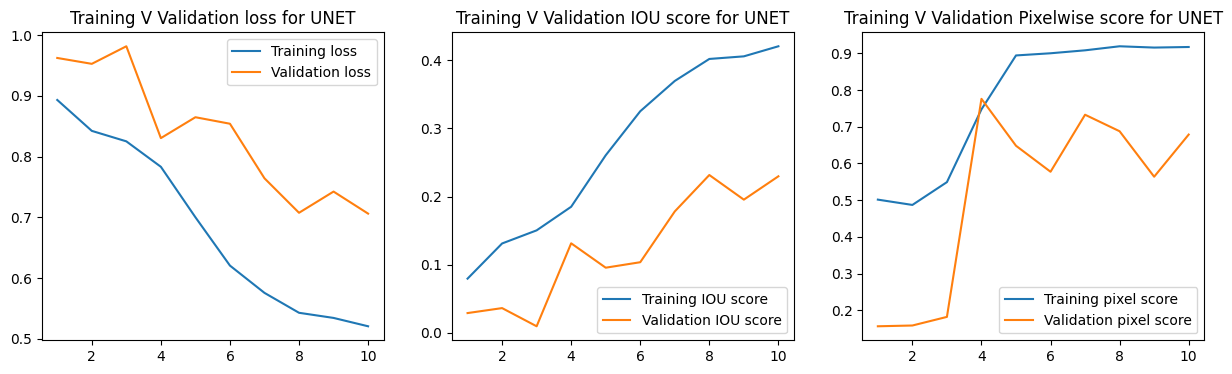

In [ ]:
graph(history=history)

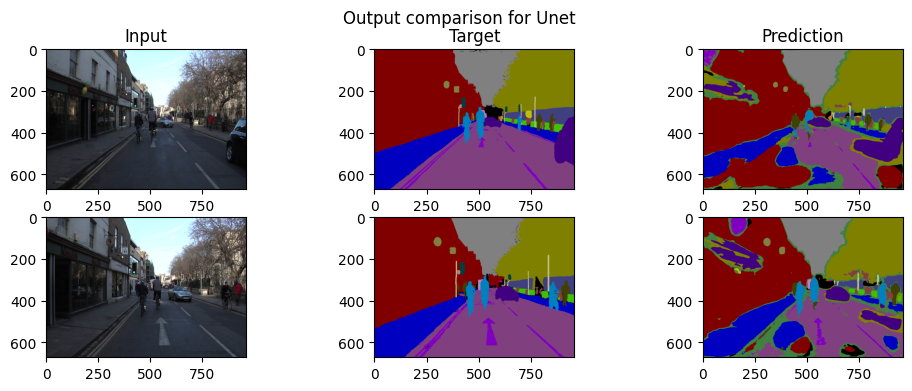

In [ ]:
output_im(x_test,y_test,m_argmax)

#PSP Results

In [ ]:
test_acc(y_test,m)

PSP Pixelwise accuracy for test data: 90.87066254058442


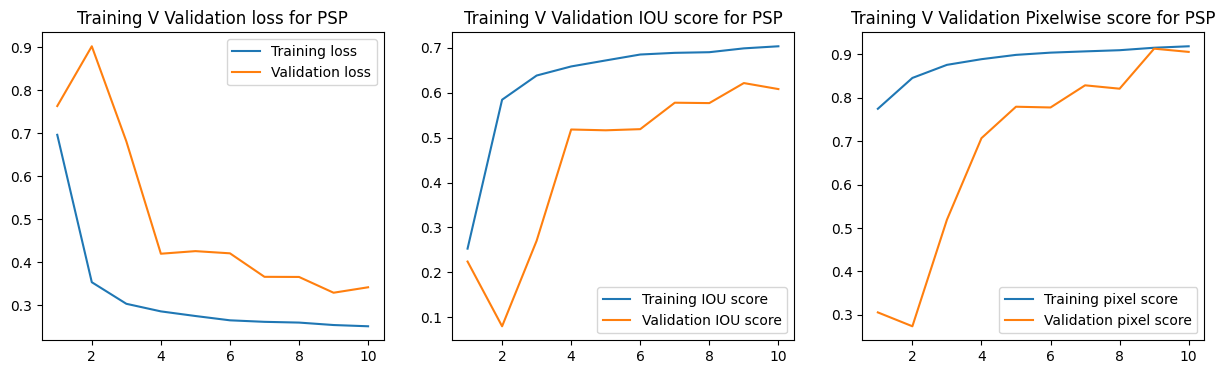

In [ ]:
graph(history=history)

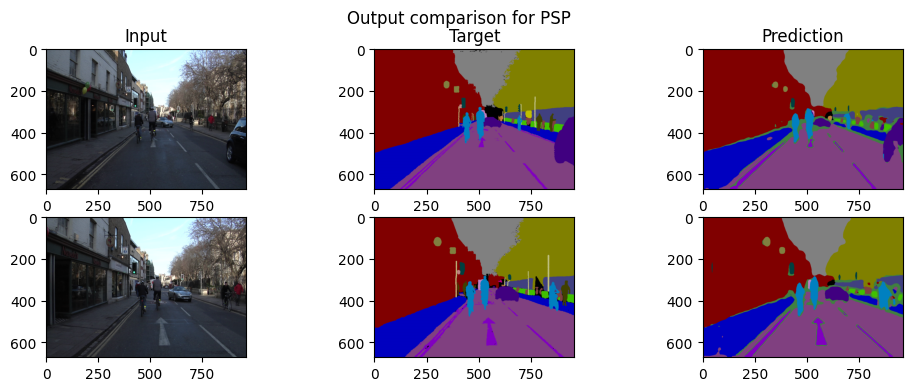

In [ ]:
output_im(x_test,y_test,m_argmax)

#FPN Results

In [29]:
test_acc(y_test,m)

FPN Pixelwise accuracy for test data: 91.23041238275614


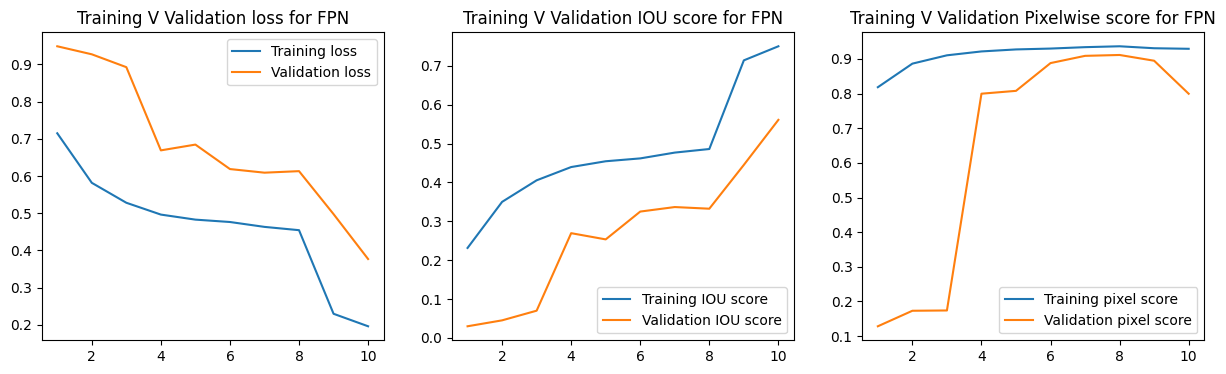

In [23]:
graph(history=history)

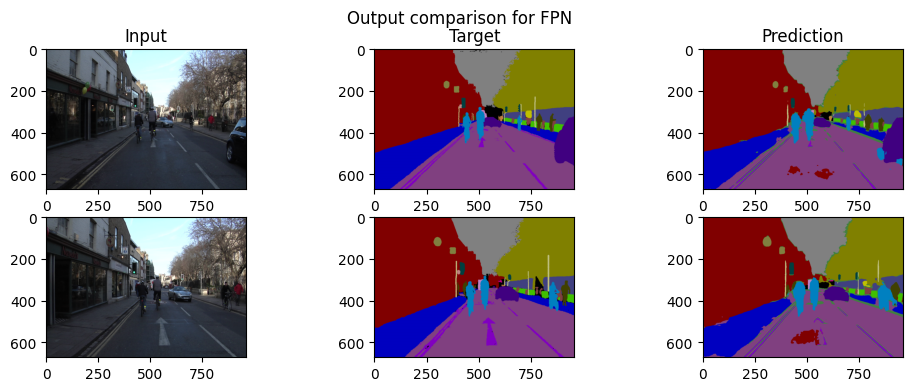

In [31]:
output_im(x_test,y_test,m_argmax)